In [80]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform

from gw_eccentricity import load_waveform, load_data, get_available_methods, measure_eccentricity
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs

from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#

#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200
#plt.rcParams["font.family"] = "monospace"
 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt
#plt.style.reload_library()
#plt.style.use(['science','notebook'])



#pylab.rc('xtick', labelsize=18) 
#pylab.rc('ytick', labelsize=18) 
#pylab.rc('axes', labelsize=16)
#pylab.rc('legend', fontsize=15)


In [7]:
# Eq. (4.17a, 4.17b), Pg. 18, Moore et al (2016)

def epsilon(xi, eta):
    return(( 1 + ( ( -2833/2016 + 197/72 * eta ) * ( xi )**( 2/3 ) + 
                  ( -377/144 * np.pi * xi + ( ( 77006005/24385536 + ( -1143767/145152 * eta + 
 	 43807/10368 * ( eta )**( 2 ) ) ) * ( xi )**( 4/3 ) + ( np.pi * ( 9901567/1451520 + 
 	 -202589/362880 * eta ) * ( xi )**( 5/3 ) + ( xi )**( 2 ) * ( -33320661414619/386266890240 + 
 	 ( 3317/252 * EulerGamma + ( 180721/41472 * ( np.pi )**( 2 ) + ( ( 161339510737/8778792960 + 
 	 3977/2304 * ( np.pi )**( 2 ) ) * eta + ( -359037739/20901888 * ( eta )**( 2 ) + 
      ( 10647791/2239488 * ( eta )**( 3 ) + ( -87419/3780 * np.log( 2 ) + 
 	 ( 26001/1120 * np.log( 3 ) + 3317/504 * np.log( 16 * ( xi )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ))

In [8]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('tshift_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e**3 + A[6]*e*q + A[7]*(e**2)*q + A[8]*e*(q**2) + A[9]*(e**2)*(q**2) + A[10]*(e**3)*q + A[11]*e*q*math.cos(l + A[12]) + A[13]*(e**2)*(q**2)*math.cos(e*l + A[14]) + A[15]*(e**3)*q*math.cos(l + A[16]) + A[17]*e*(q**2)*math.cos(l + A[18])

g=open('tamp_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e**3 + B[6]*e*eta + B[7]*(e**2)*eta + B[8]*e*(eta**2) + B[9]*(e**2)*(eta**2) + B[10]*(e**3)*eta + B[11]*e*eta*math.cos(l + B[12]) + B[13]*(e**2)*(eta**2)*math.cos(l + B[14]) + B[15]*(e**3)*eta*math.cos(e*l + B[16])

g=open('tfreq_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e**3 + C[6]*e*eta + C[7]*(e**2)*eta + C[8]*e*(eta**2) + C[9]*(e**2)*(eta**2) + C[10]*(e**3)*eta + C[11]*e*eta*math.cos(l + C[12]) + C[13]*(e**2)*(eta**2)*math.cos(l + C[14]) + C[15]*(e**3)*eta*math.cos(e*l + C[16])+ C[17]*(e**3)*(eta**2)*math.cos(e*l + C[18])

In [9]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion


In [7]:
def INSP_Eber22(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=((M0*MTSUN_SI*math.pi*flow)**(2/3))
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": xlow**(3/2),  #xlow = 0.045 corresponds to 616 Hz. For PN-NR comp. use 0.045, For match calculation use 0.053
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode2polfac=(5/(64*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp22 = np.real(dataDict2["hlm"][(2,2)])
    hc22 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp22-1j*hc22)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec

    phs=phs-phs[0]
    
    lp=2
    mp=2
    
    j=0
    h22=[]
    h2_2=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h22.append(hlm) 
        h2_2.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph22, sph2_2 = sph_harmonics(incl,lp)
    
    h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode2polfac=(5/(64*np.pi))**(1/2) 
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new2 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new2 = hp_intrp_new(t_intrp_new2)
    hc_intrp_new2 = hc_intrp_new(t_intrp_new2)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new2), np.array(hc_intrp_new2), np.array(t_intrp_new2)

In [8]:
hp22,hc22,time22=INSP_Eber22(40,2,0.081,-0.181,20,0,1,1./4096)

100%|████████████████████████████████████| 97532/97532 [01:43<00:00, 939.75it/s]


In [21]:
M0=40
d=1
M_SI=M0*MSUN_SI
D_SI=(10**(6)) * PC_SI * 1

In [14]:
def PNparams(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                             delta_t=delta_t, 
                             f_lower=f_low, 
                             eccentricity=e0,
                             distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    
    return phase_EccTD, tVec_PN

In [11]:
def old_INSP_Eber22(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=c=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    eta=nu=neu
    gamma=EulerGamma=0.577215664901
    mode2polfac=(5/(64*np.pi))**(1/2)
    
    conv=M*MTSUN_SI
    M_SI=M * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
    print(xlow)
    f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
    %run GW_functions.ipynb
    
    x=xlow
    v=math.sqrt(x)
    
    xie=v**3
    
    if delta_t>=1/2**14:
        del_t = 1/2**14
    elif delta_t<1/2**14 and delta_t>=1/2**16:
        del_t = 1/2**16
    elif delta_t<1/2**16 and delta_t>=1/2**18:
        del_t = 1/2**18
    else:
        del_t = 1/2**20
        
    phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    print(phase_EccTD[0])
    tC_NR = 0
    
    x0=xlow
    xi0=x0**(3/2)
    v0=xi0**(1/3)
   
    theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
    theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
    fVec=x_from_t(theta, theta0, e0, M, eta)
    
    plotIdx2=np.nonzero(fVec>=0)
    fVec=fVec[plotIdx2]
    xiVec=(np.pi*M*fVec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xband=np.where(xVec<=1/6)
    xVec = xVec[xband]
    maxPNidx = len(xVec)
    tVec_PN=tVec_PN[:maxPNidx]
    
    
    lp=2
    mp=2
    
    j=0
    h22=[]
    h2_2=[]
    for i in xVec:    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=mean_anomaly(xie, xi0, l0, eta, e0)
        e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
        psi=phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
        
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h22.append(hlm)
        h2_2.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph22, sph2_2 = sph_harmonics(inc,lp)
    
    h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2)
    hp=(np.real(h)) 
    hc=(np.imag(h)) 
    time = tVec_PN #- tVec_PN[-1]

    #mode2polfac=(5/(64*np.pi))**(1/2)  
    
    hp = np.array(hp)
    hc = np.array(hc)
    time = tVec_PN
    
    hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp = np.arange(time[0], time[-1], delta_t)
    hp_intrp = hp_intrp(t_intrp)
    hc_intrp = hc_intrp(t_intrp)
    
    return np.array(hp_intrp), np.array(hc_intrp), np.array(t_intrp)

In [12]:
Hp,Hc,T = old_INSP_Eber22(40,2,0.12,-0.181,20,0,1,1./4096)
Time22 = time22/(M0*MTSUN_SI)
Hp22 = hp22/(G_SI*M_SI/D_SI/C_SI/C_SI)

0.05351303645094325
0.0


In [13]:
f_low = 20
sample_rate = 4096
tlen = max(len(Hp), len(Hp22))
hp22Vec_SI = TimeSeries(Hp22, delta_t=1./sample_rate)
HpVec_SI = TimeSeries(Hp, delta_t=1./sample_rate)
#?TimeSeries
HpVec_SI.resize(tlen)
hp22Vec_SI.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / hp22Vec_SI.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(HpVec_SI, hp22Vec_SI, psd=psd, low_frequency_cutoff=f_low)
print('The match is: {:.4f}'.format(m))

The match is: 0.8866


# Amplitude same - phase different

In [19]:
def old1_INSP_Eber22(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=((M0*MTSUN_SI*math.pi*flow)**(2/3))
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": 0.081,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": xlow**(3/2),  #xlow = 0.045 corresponds to 616 Hz. For PN-NR comp. use 0.045, For match calculation use 0.053
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode2polfac=(5/(64*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp22 = np.real(dataDict2["hlm"][(2,2)])
    hc22 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp22-1j*hc22)*2)/2
    phs=phs-phs[0]
    PHASE = interp1d(Time_data1,phs,kind='cubic',fill_value='extrapolate')
    
    eta=neu=nu=q/(1+q)**2
    G=c=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    eta=nu=neu
    gamma=EulerGamma=0.577215664901
    mode2polfac=(5/(64*np.pi))**(1/2)
    
    conv=M*MTSUN_SI
    M_SI=M * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
    print(xlow)
    f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
    %run GW_functions.ipynb
    
    x=xlow
    v=math.sqrt(x)
    
    xie=v**3
    
    if delta_t>=1/2**14:
        del_t = 1/2**14
    elif delta_t<1/2**14 and delta_t>=1/2**16:
        del_t = 1/2**16
    elif delta_t<1/2**16 and delta_t>=1/2**18:
        del_t = 1/2**18
    else:
        del_t = 1/2**20
        
    phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    
    
    Del_t = np.abs(np.mean((np.diff(tVec_PN)))) 
    tt = np.arange(tVec_PN[0],tVec_PN[-1],Del_t)
    phase_EccTD = PHASE(tt)
    phase_EccTD = phase_EccTD-phase_EccTD[0]
    print(phase_EccTD[0])
    tC_NR = 0
    
    x0=xlow
    xi0=x0**(3/2)
    v0=xi0**(1/3)
   
    theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
    theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
    fVec=x_from_t(theta, theta0, e0, M, eta)
    
    plotIdx2=np.nonzero(fVec>=0)
    fVec=fVec[plotIdx2]
    xiVec=(np.pi*M*fVec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xband=np.where(xVec<=1/6)
    xVec = xVec[xband]
    maxPNidx = len(xVec)
    tVec_PN=tVec_PN[:maxPNidx]
    
    
    lp=2
    mp=2
    
    j=0
    h22=[]
    h2_2=[]
    for i in xVec:    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=mean_anomaly(xie, xi0, l0, eta, e0)
        e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
        psi=phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
        
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h22.append(hlm)
        h2_2.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph22, sph2_2 = sph_harmonics(inc,lp)
    
    h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2)
    hp=(np.real(h)) 
    hc=(np.imag(h)) 
    time = tVec_PN #- tVec_PN[-1]

    #mode2polfac=(5/(64*np.pi))**(1/2)  
    
    hp = np.array(hp)
    hc = np.array(hc)
    time = tVec_PN
    
    hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp = np.arange(time[0], time[-1], delta_t)
    hp_intrp = hp_intrp(t_intrp)
    hc_intrp = hc_intrp(t_intrp)
    
    return np.array(hp_intrp), np.array(hc_intrp), np.array(t_intrp)

0.05351303645094325
0.0


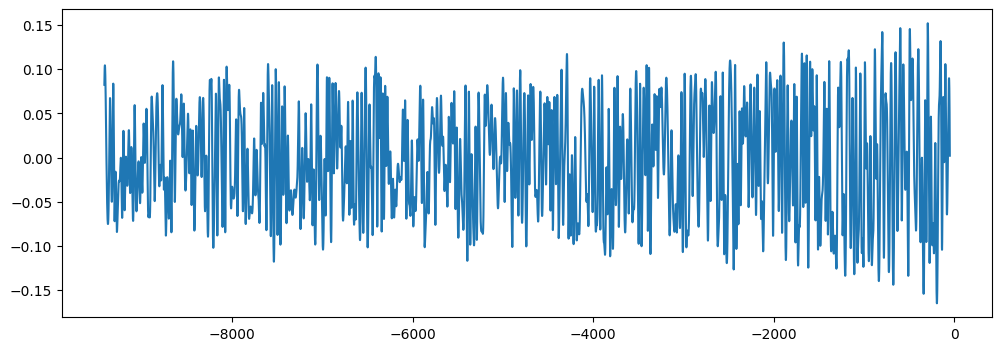

In [20]:
Hp1,Hc1,T1 = old1_INSP_Eber22(40,2,0.12,-0.181,20,0,1,1./4096)
plt.figure(figsize=(12,4))
plt.plot(T1,Hp1)
#plt.xlim(-2000,0)

In [ ]:
f_low = 20
sample_rate = 4096
tlen = max(len(Hp), len(Hp1))
hp22Vec_SI = TimeSeries(Hp1, delta_t=1./sample_rate)
HpVec_SI = TimeSeries(Hp, delta_t=1./sample_rate)
#?TimeSeries
HpVec_SI.resize(tlen)
hp22Vec_SI.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / hp22Vec_SI.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(HpVec_SI, hp22Vec_SI, psd=psd, low_frequency_cutoff=f_low)
print('The match is: {:.4f}'.format(m))

# Amplitude different - phase same

In [10]:
def INSP_Eber22(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=((M0*MTSUN_SI*math.pi*flow)**(2/3))
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": xlow**(3/2),  #xlow = 0.045 corresponds to 616 Hz. For PN-NR comp. use 0.045, For match calculation use 0.053
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode2polfac=(5/(64*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp22 = np.real(dataDict2["hlm"][(2,2)])
    hc22 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp22-1j*hc22)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec

    phs=phs-phs[0]
    
    lp=2
    mp=2
    
    j=0
    h22=[]
    h2_2=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h22.append(hlm) 
        h2_2.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph22, sph2_2 = sph_harmonics(incl,lp)
    
    h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode2polfac=(5/(64*np.pi))**(1/2) 
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new2 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new2 = hp_intrp_new(t_intrp_new2)
    hc_intrp_new2 = hc_intrp_new(t_intrp_new2)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new2), np.array(hc_intrp_new2), np.array(t_intrp_new2)

In [11]:
hp22,hc22,time22=INSP_Eber22(40,2,0.081,-0.181,20,0,1,1./4096)

100%|███████████████████████████████████| 97532/97532 [01:34<00:00, 1033.06it/s]


In [15]:
def old1_INSP_Eber22(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=((M0*MTSUN_SI*math.pi*flow)**(2/3))
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": 0.081,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": xlow**(3/2),  #xlow = 0.045 corresponds to 616 Hz. For PN-NR comp. use 0.045, For match calculation use 0.053
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode2polfac=(5/(64*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp22 = np.real(dataDict2["hlm"][(2,2)])
    hc22 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp22-1j*hc22)*2)/2
    phs=phs-phs[0]
    PHASE = interp1d(Time_data1,phs,kind='cubic',fill_value='extrapolate')
    
    eta=neu=nu=q/(1+q)**2
    G=c=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    eta=nu=neu
    gamma=EulerGamma=0.577215664901
    mode2polfac=(5/(64*np.pi))**(1/2)
    
    conv=M*MTSUN_SI
    M_SI=M * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
    print(xlow)
    f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
    %run GW_functions.ipynb
    
    x=xlow
    v=math.sqrt(x)
    
    xie=v**3
    
    if delta_t>=1/2**14:
        del_t = 1/2**14
    elif delta_t<1/2**14 and delta_t>=1/2**16:
        del_t = 1/2**16
    elif delta_t<1/2**16 and delta_t>=1/2**18:
        del_t = 1/2**18
    else:
        del_t = 1/2**20
        
    phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    
    
    Del_t = np.abs(np.mean((np.diff(tVec_PN)))) 
    tt = np.arange(tVec_PN[0],tVec_PN[-1],Del_t)
    phase_EccTD = PHASE(tt)
    phase_EccTD = phase_EccTD-phase_EccTD[0]
    print(phase_EccTD[0])
    tC_NR = 0
    
    x0=xlow
    xi0=x0**(3/2)
    v0=xi0**(1/3)
   
    theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
    theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
    fVec=x_from_t(theta, theta0, e0, M, eta)
    
    plotIdx2=np.nonzero(fVec>=0)
    fVec=fVec[plotIdx2]
    xiVec=(np.pi*M*fVec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xband=np.where(xVec<=1/6)
    xVec = xVec[xband]
    maxPNidx = len(xVec)
    tVec_PN=tVec_PN[:maxPNidx]
    
    
    lp=2
    mp=2
    
    j=0
    h22=[]
    h2_2=[]
    for i in xVec:    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=mean_anomaly(xie, xi0, l0, eta, e0)
        e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
        psi=phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
        
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h22.append(hlm)
        h2_2.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph22, sph2_2 = sph_harmonics(inc,lp)
    
    h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2)
    hp=(np.real(h)) 
    hc=(np.imag(h)) 
    time = tVec_PN #- tVec_PN[-1]

    #mode2polfac=(5/(64*np.pi))**(1/2)  
    
    hp = np.array(hp)
    hc = np.array(hc)
    time = tVec_PN
    
    hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp = np.arange(time[0], time[-1], delta_t)
    hp_intrp = hp_intrp(t_intrp)
    hc_intrp = hc_intrp(t_intrp)
    
    return np.array(hp_intrp), np.array(hc_intrp), np.array(t_intrp)

In [16]:
Hp1,Hc1,T1 = old1_INSP_Eber22(40,2,0.12,-0.181,20,0,1,1./4096)

0.05351303645094325
0.0


In [22]:
Time22 = time22/(M0*MTSUN_SI)
Hp22 = hp22/(G_SI*M_SI/D_SI/C_SI/C_SI)


f_low = 20
sample_rate = 4096
tlen = max(len(Hp1), len(Hp22))
hp22Vec_SI = TimeSeries(Hp1, delta_t=1./sample_rate)
HpVec_SI = TimeSeries(Hp22, delta_t=1./sample_rate)
#?TimeSeries
HpVec_SI.resize(tlen)
hp22Vec_SI.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / hp22Vec_SI.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(HpVec_SI, hp22Vec_SI, psd=psd, low_frequency_cutoff=f_low)
print('The match is: {:.4f}'.format(m))

The match is: 0.8866


# Mismatch Model v/s NR

In [146]:
%run New_HM_MODEL_EOBv4HM.ipynb

(array([  478,   479,   480, ..., 20347, 20348, 20349]),)
19872


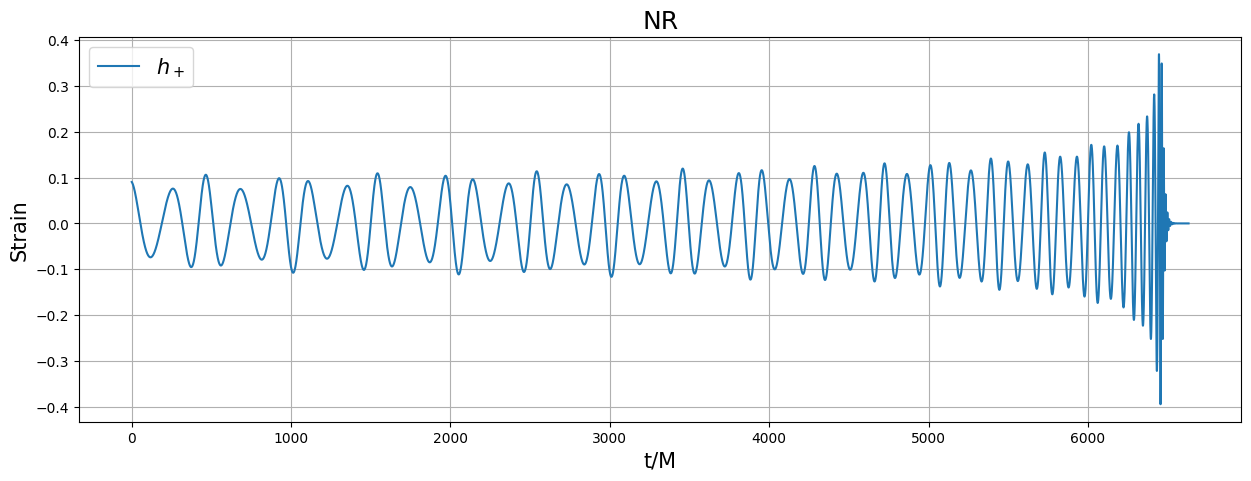

In [147]:
simulation = '/home/pratul/Downloads/1356_rhOverM_Asymptotic_GeometricUnits_CoM.h5'
tref=320.0
sims = simulation.split('_')[0]
lp = 2 #modes
mp = 2
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

plt.figure(figsize=(15,5))
plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
plt.title("NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})

In [148]:
q=1
i= 40 #total mass
e= 0.163
li=1.574
x0 = 0.045

angle=10
M1=i*q/(q+1)    
M2=i/(q+1)
M=i
flow = x0**(3/2)/(M*MTSUN_SI*math.pi)
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_NR = x1

tVec_SI=tVec_NR*M*MTSUN_SI;
#hpVec_SI=y1*G_SI*M_SI/D_SI/C_SI/C_SI;
delta_t_NR=np.mean(np.diff(tVec_SI))
hp, hc = eccmodel(M,q,e,li,flow,inclination=10,d=1,delta_t=delta_t_NR)
time = np.linspace(0,x1[-1],len(hp))
print(flow)

15.422663198817306


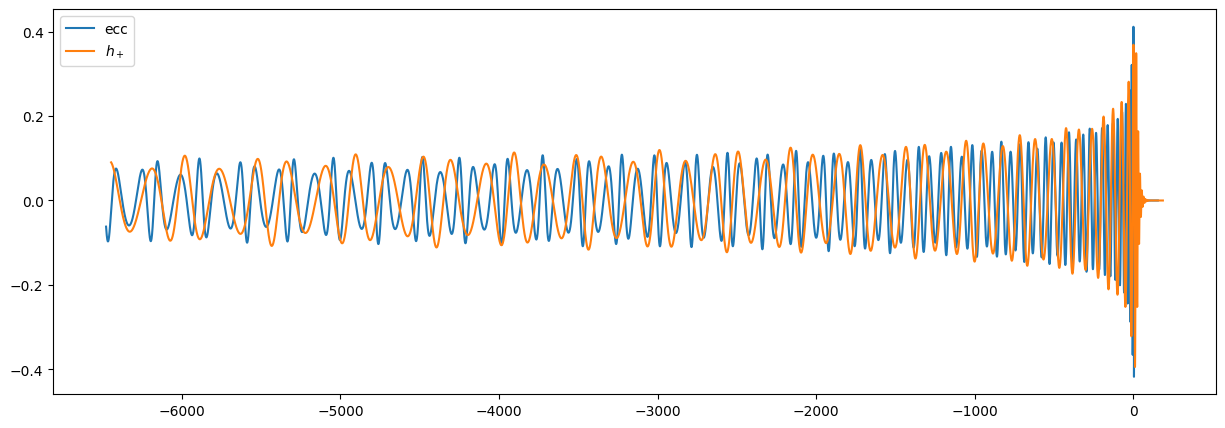

In [150]:
plt.figure(figsize=(15,5))
AMP = abs(hp-1j*hc)/((mode2polfac/2)*(G_SI*M_SI/D_SI/C_SI/C_SI))
Hplus = hp/((mode2polfac/2)*(G_SI*M_SI/D_SI/C_SI/C_SI))
#plt.ylim(1e-4,1)
#plt.xlim(-6200,100)
plt.plot(time-time[np.argmax(Hplus)],Hplus,label='ecc') #IN MODELECC22 we used (mode2polfac/4) where there is a 1/2 factor included in sph_harm
plt.plot(x1-x1[np.argmax(y1)],y1,label='$h_+$')
plt.legend()

In [152]:
f_low = flow
sample_rate = 1/delta_t_NR
tlen = max(len(Hplus), len(y1))
hp22Vec_SI = TimeSeries(Hplus, delta_t=1./sample_rate)
HpVec_SI = TimeSeries(y1, delta_t=1./sample_rate)
#?TimeSeries
HpVec_SI.resize(tlen)
hp22Vec_SI.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / hp22Vec_SI.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(HpVec_SI, hp22Vec_SI, psd=psd, low_frequency_cutoff=f_low)
print('The match is: {:.4f}'.format(m))

The match is: 0.2172


In [4]:
def freq(j):
    return(0.045**(3/2)/(j*MTSUN_SI*math.pi))
print(freq(40))

15.422663198817306
